# Classifier
ReLU activation, 4 layers, 100 neurons per layer
Validation score use ensemble of 10 models weighted by loss

### TODO:

- What metrics to use during training?
- Which plots are needed?


### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import tensorflow as tf
import pandas as pd
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *
from keras.models import load_model

#dirLoc = '../Data/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss"
#dirLoc = '../Data_3Fold/'
#name = "weights/ReLU_Baseline_CLR_AsimovLoss_3Fold"
dirLoc = '../Data_SUSY/'
name = "weights/ReLU_Baseline_CLR_AsimovLoss_SUSY"

name_pretrain = name.replace('weights/', 'weights/PRETRAIN_')

Using TensorFlow backend.


## Prep SUSY data

In [ ]:
from Modules.Data_Import import prepareSample, getPreProcPipes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

nFolds = 10
features = [
    'HT','MET','MT','MT2W','n_jet',
    'n_bjet','sel_lep_pt0','sel_lep_eta0','sel_lep_phi0',
    'selJet_phi0','selJet_pt0','selJet_eta0','selJet_m0',
    'selJet_phi1','selJet_pt1','selJet_eta1','selJet_m1',
    'selJet_phi2','selJet_pt2','selJet_eta2','selJet_m2',
]

df = pd.read_pickle('../../dfs/combinedleonid.pkl')
df.drop(columns=list(k for k in df.keys() if k not in features+['signal']), inplace=True)
df.rename(index=str, columns={"signal": "gen_target"}, inplace=True)
df['EventId'] = df.index.tolist()
df['gen_weight_original'] = 1.
df['gen_weight'] = 1.
df.fillna(0,inplace=True)

# 20% test, 16% validation, rest training
train, test = train_test_split(df, test_size=0.2, random_state=492)
train, val = train_test_split(train, test_size=0.2, random_state=492)

# a thing that's applied in Higgs analysis...
# convertData(trainingData, rotate, cartesian)
# convertData(test, rotate, cartesian)

data = {
    'train': train[features + ['gen_target', 'gen_weight', 'gen_weight_original']],
    'val': val[features + ['gen_target', 'gen_weight', 'gen_weight_original']],
    'test': test,
    'features': features
}

# rest copied from Modules.Data_Import.runDataImport:
inputPipe, _ = getPreProcPipes(normIn=True)
inputPipe.fit(data['train'][data['features']].values.astype('float32'))
with open(dirLoc + 'inputPipe.pkl', 'wb') as fout:
    pickle.dump(inputPipe, fout)

prepareSample(data['train'], 'train', inputPipe, False, nFolds, data['features'], dirLoc)
prepareSample(data['val'], 'val', inputPipe, False, nFolds, data['features'], dirLoc)
prepareSample(data['test'], 'testing', inputPipe, False, nFolds, data['features'], dirLoc)

with open(dirLoc + 'features.pkl', 'wb') as fout:
    pickle.dump(data['features'], fout)

## Options

In [2]:
with open(dirLoc + 'features.pkl', 'rb') as fin:
    classTrainFeatures = pickle.load(fin)

In [3]:
nSplits = 10
patience = 50
maxEpochs = 200
preTrainMaxEpochs = 10

ensembleSize = 10
ensembleMode = 'loss'

compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':'modelRelu', 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

plot_while_training = True

print ("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


# b = 100000  # test
# t = 250000  # training
# v = 450000  # test

# sig weight sum:  1383.97719575 in 550000
# bkg weight sum:  821999.696026 in 550000

# expected signal and background numbers
lumi=30.
s_exp=228.195*0.14*lumi #leonid's number
b_exp=844000.*8.2e-4*lumi #cross section of ttbar sample in fb times efficiency measured by Marco

print ('_S%.2e'%s_exp).replace('.', 'd').replace('+','p').replace('-','m')
print ('_B%.2e'%b_exp).replace('.', 'd').replace('+','p').replace('-','m')

new_loss_functions = get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp)

def plotLoss(history):
    val_loss = history['val_loss']
    plt.plot(history['val_train_loss'],label='train')
    plt.plot(val_loss,label='test')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if max(val_loss) > 20*min(val_loss) and min(val_loss)>0:
        plt.yscale('log')
    plt.legend(loc='best')
#    plt.savefig(os.path.join(self.output,'lossEvolution.pdf'))
#    plt.clf()
    plt.show()

('\nTraining on', 21, 'features:', ['HT', 'MET', 'MT', 'MT2W', 'n_jet', 'n_bjet', 'sel_lep_pt0', 'sel_lep_eta0', 'sel_lep_phi0', 'selJet_phi0', 'selJet_pt0', 'selJet_eta0', 'selJet_m0', 'selJet_phi1', 'selJet_pt1', 'selJet_eta1', 'selJet_m1', 'selJet_phi2', 'selJet_pt2', 'selJet_eta2', 'selJet_m2'])
_S9d58ep02
_B2d08ep04


## Import data

In [4]:
trainData          = BatchYielder(h5py.File(dirLoc + 'train.hdf5', "r"))
trainDataTargetMod = BatchYielderTargetMod(h5py.File(dirLoc + 'train.hdf5', "r"))
nSplits = trainData.nFolds

## Determine LR


______________________________________
Training finished
Cross-validation took 16.914s 


/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


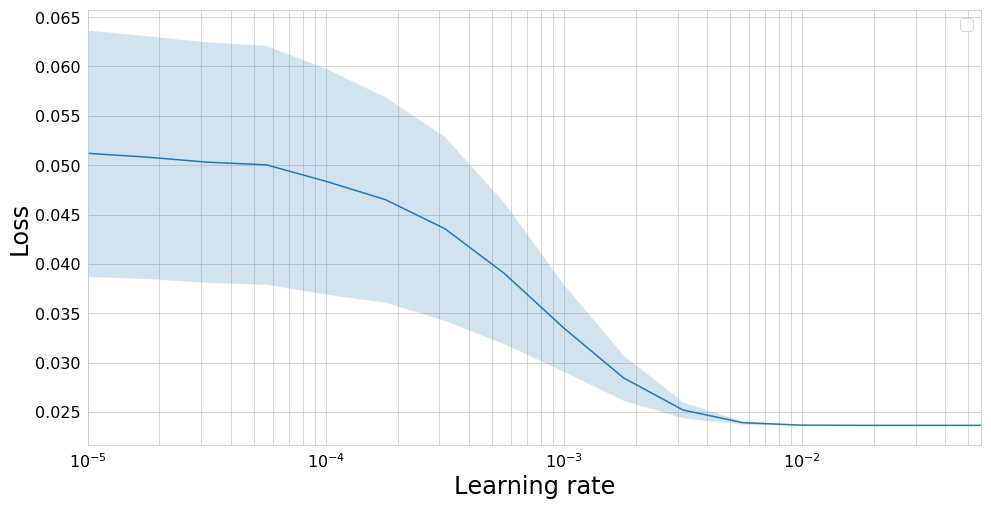

______________________________________



In [5]:
def my_model(**_):
    return model


newModelArgs = modelParams.copy()
newModelArgs['compileArgs'] = compileArgs.copy()
newModelArgs['compileArgs']['lr'] = 1e-3
trainParams['batch_size'] = 256
patience = 20  # is 50 above

#loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S9d58ep02_B2d08ep04']
loss = new_loss_functions['significanceLoss2Invert_S9d58ep02_B2d08ep04']
newModelArgs['compileArgs']['lr'] = 1e-10
newModelArgs['compileArgs']['loss'] = loss
trainParams['batch_size'] = 8192

# d = trainData
d = trainDataTargetMod

lrFinder = batchLRFind(d, getModel, newModelArgs, trainParams,# allFolds=False,
                       lrBounds=[1e-5,1e-1], trainOnWeights=True, verbose=0, binary=True)

## Train classifier

<b>Asimov-significance-loss 0.5</b> training with ``maxEpochs``

In [5]:
def _get_s_b(s_exp, b_exp, y_true, y_pred):

    # unfold encoded weights
    weights = K.abs(y_true)
    s_weights = (weights + y_true)/2.
    b_weights = (weights - y_true)/2.

    s_exp_weight = s_exp/(K.sum(s_weights)+K.epsilon())
    b_exp_weight = b_exp/(K.sum(b_weights)+K.epsilon())

    s = s_exp_weight * K.sum(y_pred * s_weights)
    b = b_exp_weight * K.sum(y_pred * b_weights)
    return s, b


def asimovSignificanceLossInvert(syst_factr, s_exp=None, b_exp=None):
    '''Define a loss function that calculates the significance based on fixed
    expected signal and expected background yields for a given batch size

    s_exp and b_exp are the number of recorded signal and background events,
    respectively (xsec*lumi).'''

    #@_patch_with_weights
    def asimovSigLossInvert(y_true, y_pred):        
        # The problem with inner_loss is that it's not monotonic when using 
        # epsilons and numerically unstable otherwise. 
        # So for a given s, there's a b value at which the function is maximal,
        # after that value the function is falling and thus promoting more
        # background events to smaller loss values.

        # coding dataflow according to:
        # https://stackoverflow.com/questions/33712178/tensorflow-nan-bug/42497444#42497444

        s, b = _get_s_b(s_exp, b_exp, y_true, y_pred)
        s += K.epsilon()
        b += K.epsilon()

        # minimal background value for inner_loss to be on the safe side.
        def max_bkg(s):
            return K.pow(s, .65)*10./K.pow(syst_factr, 0.65)
        
        b_max = max_bkg(s)
        s_b_ok = K.greater(b_max, b)
        s_b_ok = K.print_tensor(s_b_ok, 's_b_ok=')
        sb = K.stack([s,b])
        sb = K.print_tensor(sb, 'sb=')

        # Asimov loss function
        def inner_loss(sb):
            s, b = sb[0], sb[1]
            spb = s+b
            b2 = b*b
            syst = syst_factr * b
            syst2 = syst*syst
            bpsyst2 = b+syst2            
            eps = K.epsilon()
            return 0.5/(
                spb * K.log((spb*bpsyst2)/(b2+spb*syst2+eps)+eps)
                -b2/(syst2+eps) * K.log(1+syst2*s/(b*bpsyst2+eps))
            )
    
        def safe_inner_loss(sb):
            # linear function, continuing from b_max on
            s, b = sb[0], sb[1]
            b_max = max_bkg(s)
            l_b_max     = inner_loss(K.stack([s,b_max     ]))
            l_b_max0p95 = inner_loss(K.stack([s,b_max*0.95]))
            l_b_max1p05 = inner_loss(K.stack([s,b_max*1.05]))

            # vals = K.stack([l_b_max0p95,l_b_max,l_b_max1p05])
            # vals = K.print_tensor(vals, 'l_b_max=')
            # l_b_max0p95,l_b_max,l_b_max1p05 = vals[0],vals[1],vals[2]

            slope = (l_b_max1p05-l_b_max0p95) / (b_max*0.1) 
            offset = l_b_max - slope*b_max
        
            return (slope*b + offset)

        loss = K.switch(s_b_ok, inner_loss(sb), safe_inner_loss(sb))
        
        # numerical instabilities for s < 0.5 => b/s/s
        s_at_low_bound = K.greater(0.5, s)
        s_at_low_bound = K.print_tensor(s_at_low_bound, 's_at_low_bound=')
        loss = K.switch(s_at_low_bound, b/s/s, loss)
        
        return loss

    return asimovSigLossInvert

    
def get_losses_dict(syst_factors, s_exp=None, b_exp=None):
    post_fix  = ('_S%.2e'%s_exp) if s_exp else ''
    post_fix += ('_B%.2e'%b_exp) if b_exp else ''
    for before, after in (('.', 'd'), ('+','p'), ('-','m')):
        post_fix = post_fix.replace(before, after)

    d = {}
    d.update({
        (
            ('asimovSignificanceLossInvert_Sys%s'%sf).replace('.','p')+post_fix,
                asimovSignificanceLossInvert(sf, s_exp, b_exp)
        )
        for sf in syst_factors
    })

    # for keras to find the find the functions on load, the need to be named
    for func_name, func in d.iteritems():
        func.__name__ = func_name

    return d


new_loss_functions.update(get_losses_dict([0.001, 0.1, 0.3, 0.5], s_exp, b_exp))

In [6]:
newModelArgs = modelParams.copy()
loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S9d58ep02_B2d08ep04']
#loss = new_loss_functions['significanceLoss2Invert_S9d58ep02_B2d08ep04']
newModelArgs['compileArgs']['lr'] = 1e-3
#newModelArgs['compileArgs']['l2'] = 0.2
newModelArgs['compileArgs']['do'] = 0.2
#newModelArgs['compileArgs']['width'] = 23
#newModelArgs['compileArgs']['depth'] = 1
newModelArgs['compileArgs']['loss'] = loss
trainParams['batch_size'] = 8192

Using cosine annealing
Training using weights
Running fold 1 / 10
.
1 New best found: 38.3704754588
.
2 New best found: 35.9438580329
.
3 New best found: 35.3003930267
.
4 New best found: 32.8057983646
.
5 New best found: 30.6294553292
.
6 New best found: 29.5169531497
.
7 New best found: 29.309919415
.
8 New best found: 26.2077254538
.
9 New best found: 23.069205359
.
10 New best found: 20.5304899207
.
11 New best found: 18.7322179899
.
12 New best found: 17.620944468
.
13 New best found: 17.0400418819
.
14 New best found: 16.8165846716
.
15 New best found: 16.7786101248
.
16 New best found: 14.8693845525
.
17 New best found: 13.2128959808
.
18 New best found: 12.0587440213
.
19 New best found: 11.2360213485
.
20 New best found: 10.5945126128
.
21 New best found: 10.0646885726
.
22 New best found: 9.62880023854
.
23 New best found: 9.27537337644
.
24 New best found: 8.99512854301
.
25 New best found: 8.78052417404
.
26 New best found: 8.62267078056
.
27 New best found: 8.51424320776
.

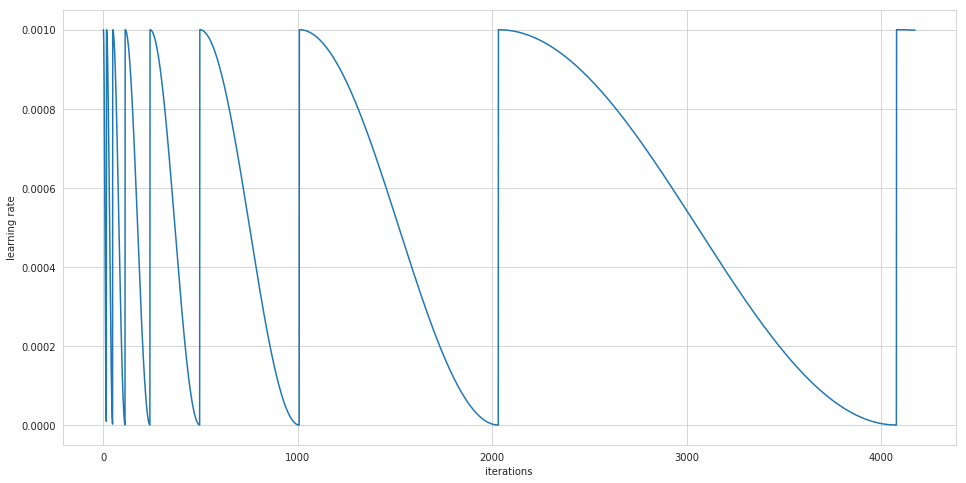

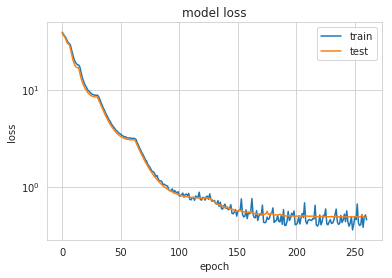

Fold took 893.482s

Running fold 2 / 10
.
1 New best found: 40.0527728752
.
2 New best found: 34.1087694091
.
3 New best found: 32.8036641112
.
4 New best found: 28.6881195569
.
5 New best found: 26.1580014799
.
6 New best found: 25.0976189009
.
7 New best found: 24.911702953
.
8 New best found: 22.4174475575
.
9 New best found: 20.3438191306
.
10 New best found: 18.8293993688
.
11 New best found: 17.7771606438
.
12 New best found: 17.1015113025
.
13 New best found: 16.7231121806
.
14 New best found: 16.5707100394
.
15 New best found: 16.5458175243
.
16 New best found: 15.1681442134
.
17 New best found: 13.9191434996
.
18 New best found: 12.9870341022
.
19 New best found: 12.2817295026
.
20 New best found: 11.7095468915
.
21 New best found: 11.2323572443
.
22 New best found: 10.8342763624
.
23 New best found: 10.5084447736
.
24 New best found: 10.2484823915
.
25 New best found: 10.0487732854
.
26 New best found: 9.90059340935
.
27 New best found: 9.79822703912
.
28 New best found: 9.73

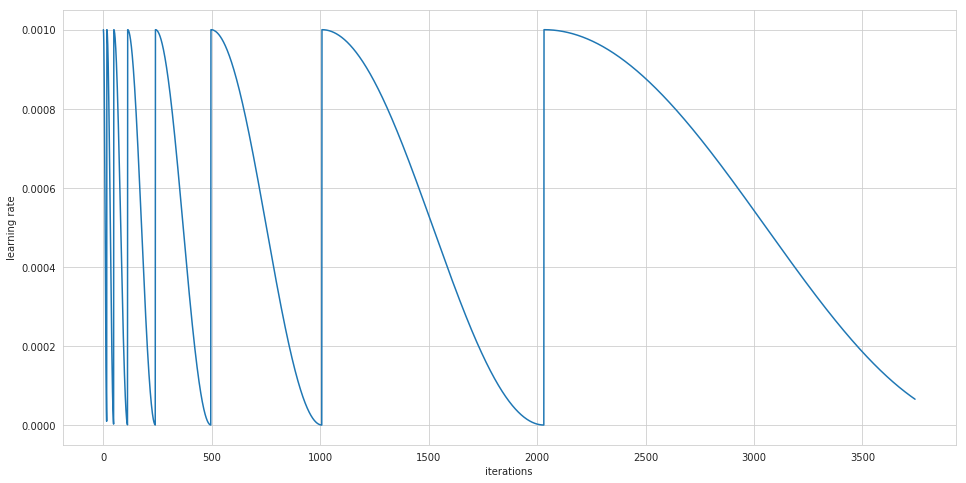

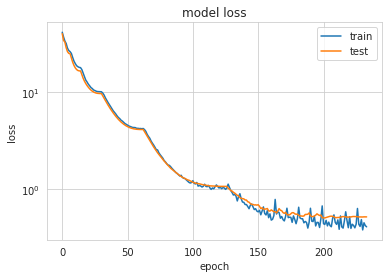

Fold took 807.512s

Running fold 3 / 10
.
1 New best found: 41.5905514073
.
2 New best found: 38.0113244112
.
3 New best found: 36.9793721313
.
4 New best found: 32.9240362293
.
5 New best found: 29.7511301005
.
6 New best found: 28.2574018088
.
7 New best found: 27.9826346003
.
8 New best found: 24.2506825969
.
9 New best found: 21.0435570113
.
10 New best found: 18.9065785011
.
11 New best found: 17.5976047607
.
12 New best found: 16.8443030953
.
13 New best found: 16.4563571889
.
14 New best found: 16.302821156
.
15 New best found: 16.2785758068
.
16 New best found: 14.9247567365
.
17 New best found: 13.6796500079
.
18 New best found: 12.6896351189
.
19 New best found: 11.9230694887
.
20 New best found: 11.307268606
.
21 New best found: 10.7912326919
.
22 New best found: 10.3625179264
.
23 New best found: 10.0136765357
.
24 New best found: 9.73487449293
.
25 New best found: 9.52095567239
.
26 New best found: 9.36323876256
.
27 New best found: 9.2536156166
.
28 New best found: 9.1850

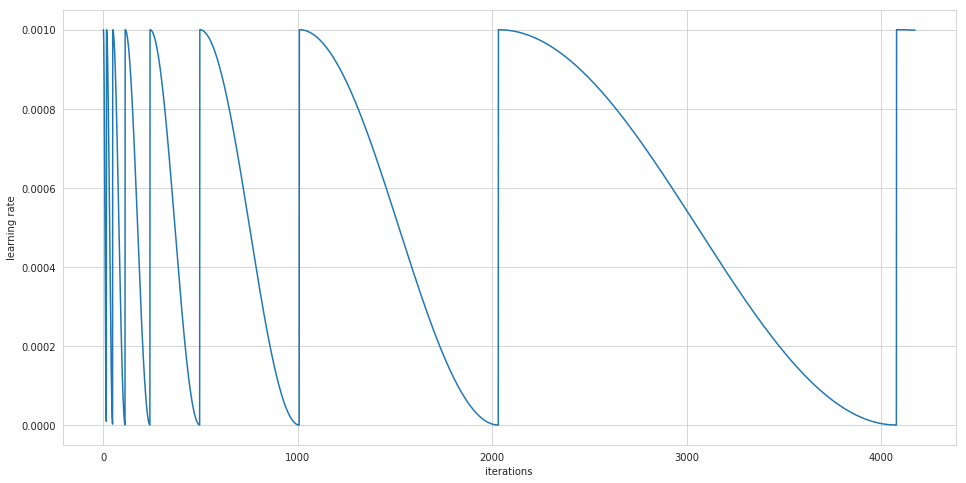

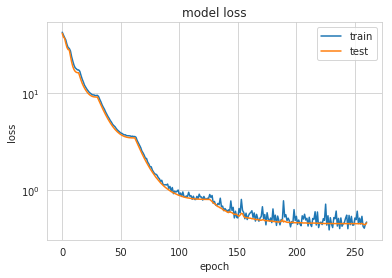

Fold took 899.424s

Running fold 4 / 10
.
1 New best found: 36.4221894531
.
2 New best found: 33.6736921997
.
3 New best found: 32.9585440979
.
4 New best found: 30.1512820282
.
5 New best found: 27.7520522766
.
6 New best found: 26.5456506653
.
7 New best found: 26.3163278809
.
8 New best found: 23.12772052
.
9 New best found: 20.2800948792
.
10 New best found: 18.3398358917
.
11 New best found: 17.1442151794
.
12 New best found: 16.4331777496
.
13 New best found: 16.0515441437
.
14 New best found: 15.9001348572
.
15 New best found: 15.8747436371
.
16 New best found: 14.4661250076
.
17 New best found: 13.1222536011
.
18 New best found: 12.0553156891
.
19 New best found: 11.2644470367
.
20 New best found: 10.6378670273
.
21 New best found: 10.1167914124
.
22 New best found: 9.68855922699
.
23 New best found: 9.34104084015
.
24 New best found: 9.06414955139
.
25 New best found: 8.85291580963
.
26 New best found: 8.6965692749
.
27 New best found: 8.58896386719
.
28 New best found: 8.5218

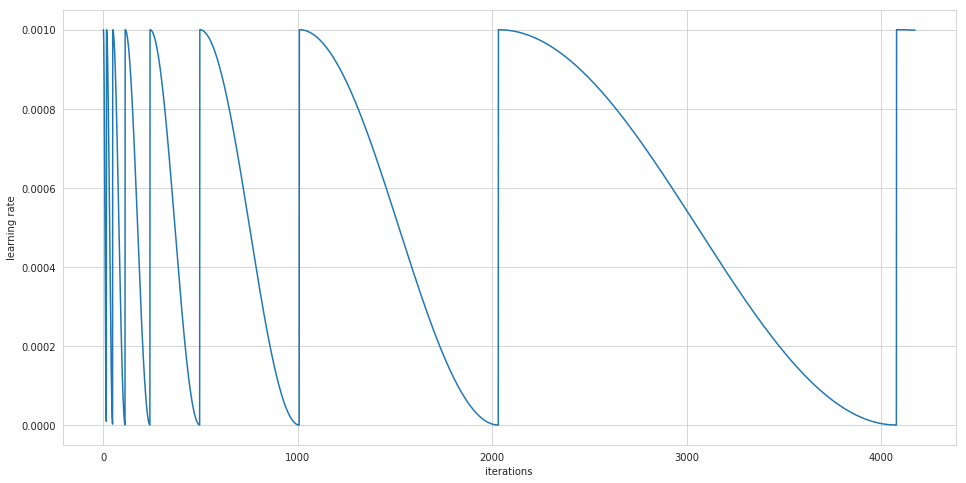

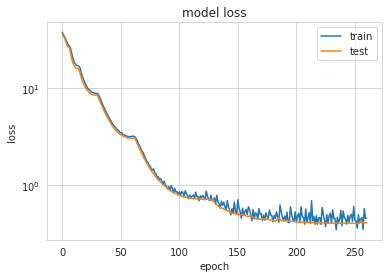

Fold took 878.712s

Running fold 5 / 10
.
1 New best found: 37.813709137
.
2 New best found: 34.9405139465
.
3 New best found: 34.2096223145
.
4 New best found: 31.5078971252
.
5 New best found: 29.2825
.
6 New best found: 28.1614129791
.
7 New best found: 27.9471405792
.
8 New best found: 24.838430954
.
9 New best found: 21.727991745
.
10 New best found: 19.3201536407
.
11 New best found: 17.7312802734
.
12 New best found: 16.7876291962
.
13 New best found: 16.3026740036
.
14 New best found: 16.1136571045
.
15 New best found: 16.0832222595
.
16 New best found: 14.4419789963
.
17 New best found: 12.9789272766
.
18 New best found: 11.9055380402
.
19 New best found: 11.1374825058
.
20 New best found: 10.5308116455
.
21 New best found: 10.0362458038
.
22 New best found: 9.63262895966
.
23 New best found: 9.30175556946
.
24 New best found: 9.04002194214
.
25 New best found: 8.83637581635
.
26 New best found: 8.68831495667
.
27 New best found: 8.5862578125
.
28 New best found: 8.52221968842

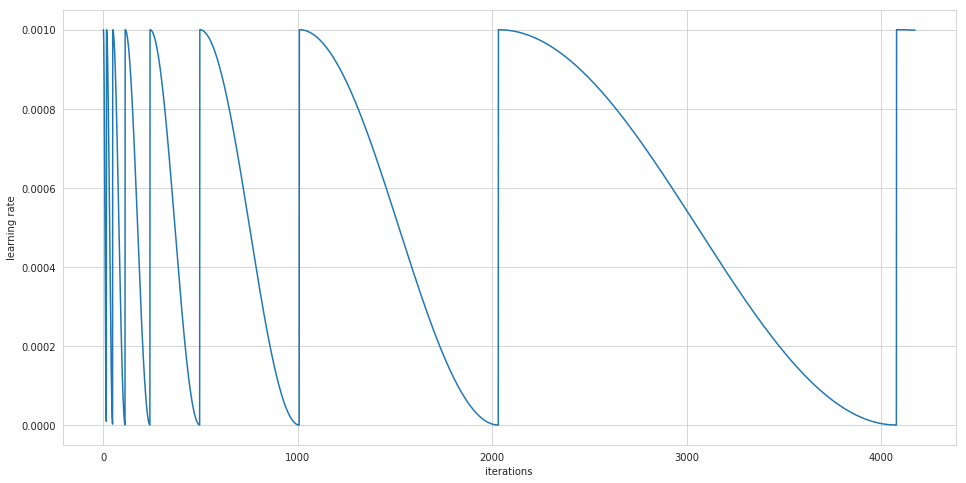

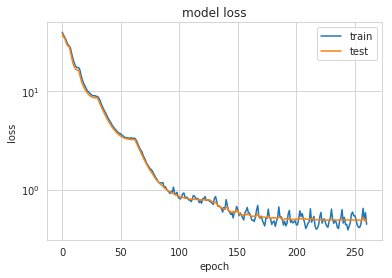

Fold took 857.960s

Running fold 6 / 10
.
1 New best found: 42.0174433289
.
2 New best found: 38.0358665161
.
3 New best found: 37.1629835205
.
4 New best found: 34.3778374023
.
5 New best found: 32.5238845825
.
6 New best found: 31.6676154785
.
7 New best found: 31.5044299622
.
8 New best found: 29.1758961334
.
9 New best found: 26.6955598755
.
10 New best found: 24.4381183624
.
11 New best found: 22.6812376404
.
12 New best found: 21.5377474976
.
13 New best found: 20.907806839
.
14 New best found: 20.6647519379
.
15 New best found: 20.6213236237
.
16 New best found: 18.5297113495
.
17 New best found: 16.7032470856
.
18 New best found: 15.2828347473
.
19 New best found: 14.156439621
.
20 New best found: 13.2024246979
.
21 New best found: 12.3863619995
.
22 New best found: 11.702098938
.
23 New best found: 11.1702881622
.
24 New best found: 10.7799916382
.
25 New best found: 10.4986423492
.
26 New best found: 10.3040014496
.
27 New best found: 10.1724073486
.
28 New best found: 10.091

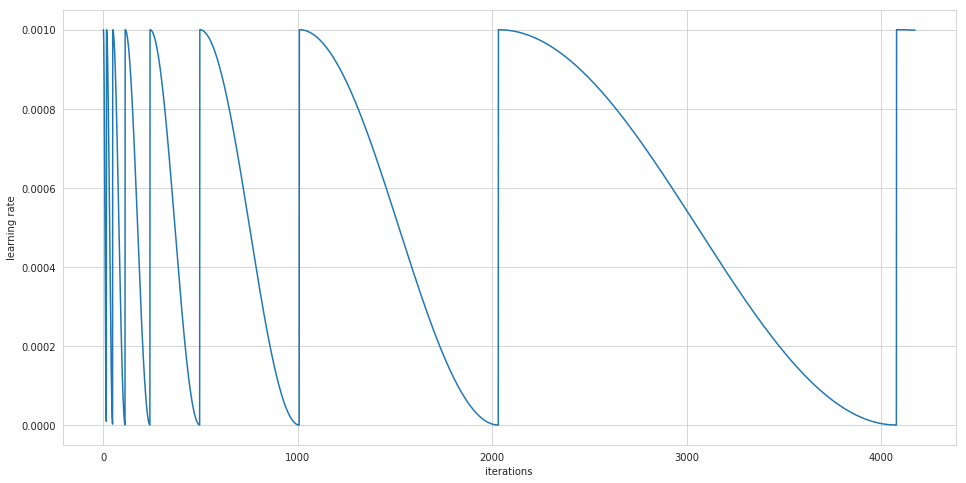

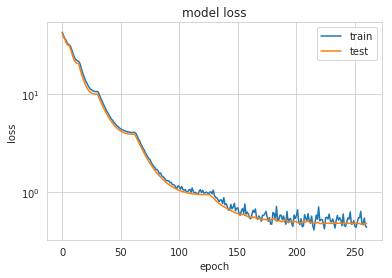

Fold took 845.903s

Running fold 7 / 10
.
1 New best found: 38.3745943298
.
2 New best found: 35.5303460083
.
3 New best found: 34.9032124939
.
4 New best found: 32.7052458496
.
5 New best found: 31.0960921326
.
6 New best found: 30.2958056641
.
7 New best found: 30.1444935608
.
8 New best found: 27.9460148163
.
9 New best found: 25.5977324829
.
10 New best found: 23.4577473602
.
11 New best found: 21.7856527252
.
12 New best found: 20.6859610901
.
13 New best found: 20.0950305634
.
14 New best found: 19.8667483215
.
15 New best found: 19.8237402954
.
16 New best found: 17.8384528046
.
17 New best found: 16.1366122437
.
18 New best found: 14.8180315247
.
19 New best found: 13.7225706635
.
20 New best found: 12.7045705414
.
21 New best found: 11.7374616852
.
22 New best found: 10.9068978119
.
23 New best found: 10.3085523529
.
24 New best found: 9.91322219849
.
25 New best found: 9.64286068726
.
26 New best found: 9.45666856384
.
27 New best found: 9.32948365784
.
28 New best found: 9.2

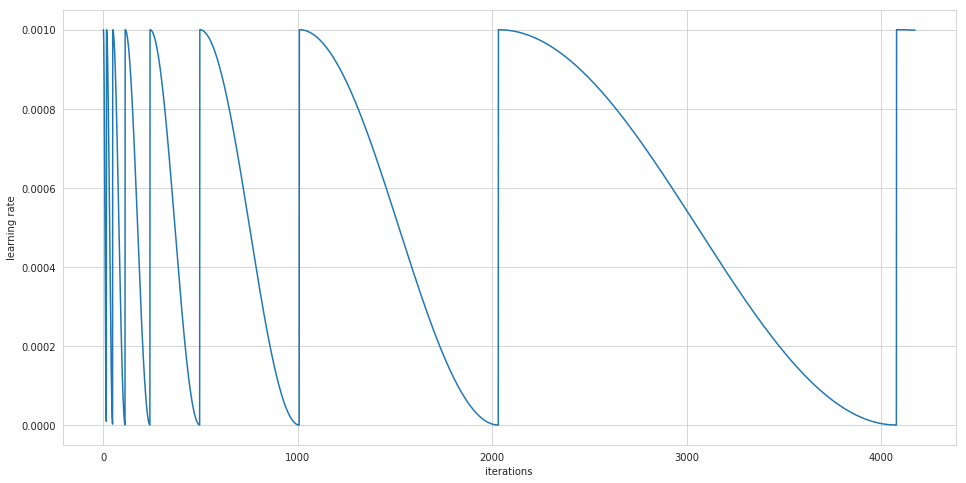

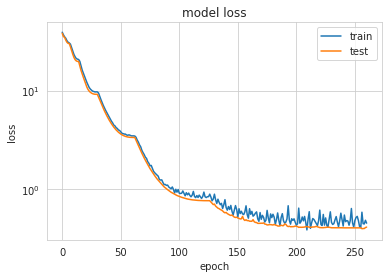

Fold took 850.337s

Running fold 8 / 10
.
1 New best found: 38.8103833951
.
2 New best found: 36.0658731229
.
3 New best found: 35.4237164225
.
4 New best found: 33.3510177755
.
5 New best found: 31.862111841
.
6 New best found: 31.1207915476
.
7 New best found: 30.9805232167
.
8 New best found: 28.8548923729
.
9 New best found: 26.4705035294
.
10 New best found: 24.1685024949
.
11 New best found: 22.2900481574
.
12 New best found: 21.0302482464
.
13 New best found: 20.3421571168
.
14 New best found: 20.077838963
.
15 New best found: 20.0331601458
.
16 New best found: 17.7669696882
.
17 New best found: 15.833619669
.
18 New best found: 14.3135876535
.
19 New best found: 13.0025927422
.
20 New best found: 11.8615140916
.
21 New best found: 10.9458705994
.
22 New best found: 10.2850707985
.
23 New best found: 9.83780991867
.
24 New best found: 9.52059818711
.
25 New best found: 9.2875341368
.
26 New best found: 9.12000530027
.
27 New best found: 9.00569169938
.
28 New best found: 8.93446

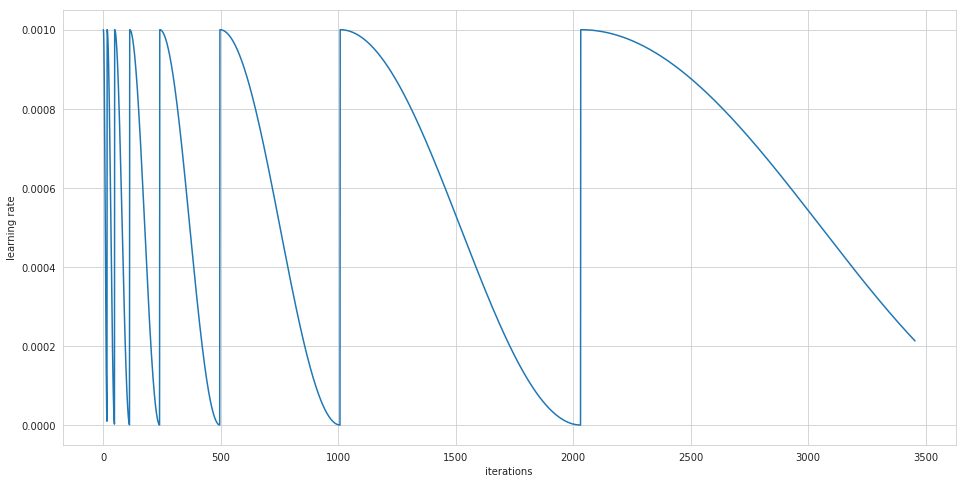

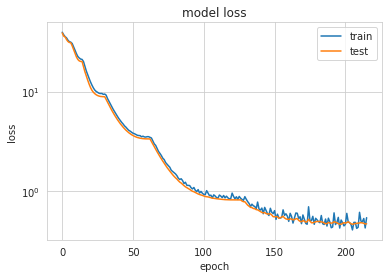

Fold took 699.050s

Running fold 9 / 10
.
1 New best found: 37.2285436786
.
2 New best found: 35.2614238616
.
3 New best found: 34.7311448059
.
4 New best found: 32.5513879457
.
5 New best found: 30.4893209149
.
6 New best found: 29.3278696344
.
7 New best found: 29.0898470096
.
8 New best found: 25.4572738849
.
9 New best found: 21.5094179767
.
10 New best found: 18.5044861838
.
11 New best found: 16.7160583512
.
12 New best found: 15.740326154
.
13 New best found: 15.2490966868
.
14 New best found: 15.0682521122
.
15 New best found: 15.0372643041
.
16 New best found: 13.4410980285
.
17 New best found: 11.9818901544
.
18 New best found: 10.9593852644
.
19 New best found: 10.2177998463
.
20 New best found: 9.62189552924
.
21 New best found: 9.1298581571
.
22 New best found: 8.72257279858
.
23 New best found: 8.39256738833
.
24 New best found: 8.13093976459
.
25 New best found: 7.92960867141
.
26 New best found: 7.7825203101
.
27 New best found: 7.681715785
.
28 New best found: 7.618341

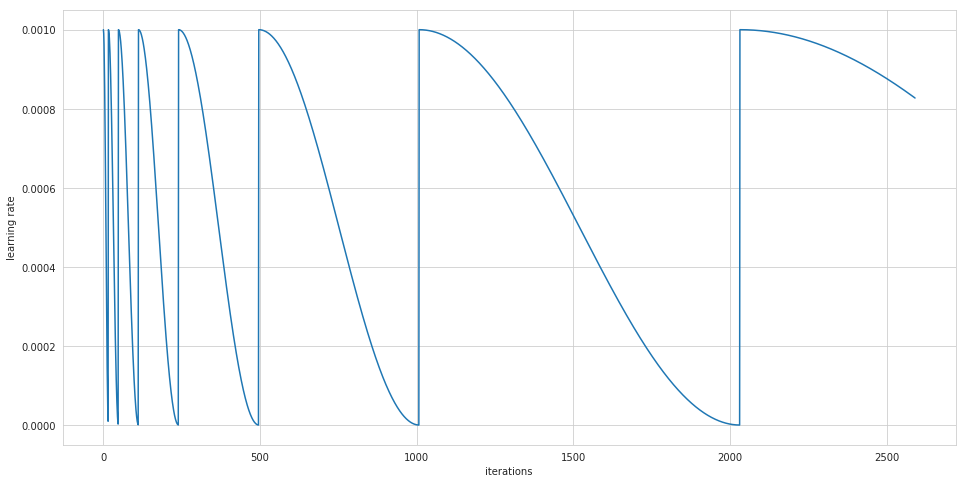

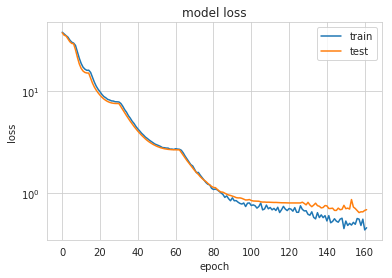

Fold took 521.216s

Running fold 10 / 10
.
1 New best found: 36.7574720646
.
2 New best found: 35.17096915
.
3 New best found: 34.7545434513
.
4 New best found: 33.2454789149
.
5 New best found: 32.0766102033
.
6 New best found: 31.4845742351
.
7 New best found: 31.3928808012
.
8 New best found: 29.7203061145
.
9 New best found: 27.6694909044
.
10 New best found: 25.4401186338
.
11 New best found: 23.4151876752
.
12 New best found: 21.9041746851
.
13 New best found: 21.027632099
.
14 New best found: 20.6732401614
.
15 New best found: 20.6172292424
.
16 New best found: 17.6074761578
.
17 New best found: 15.1215581799
.
18 New best found: 13.556609916
.
19 New best found: 12.5263458728
.
20 New best found: 11.7057313857
.
21 New best found: 10.8982197515
.
22 New best found: 9.98119201193
.
23 New best found: 9.09828842945
.
24 New best found: 8.55806838284
.
25 New best found: 8.25200274056
.
26 New best found: 8.06118545346
.
27 New best found: 7.938671706
.
28 New best found: 7.863741

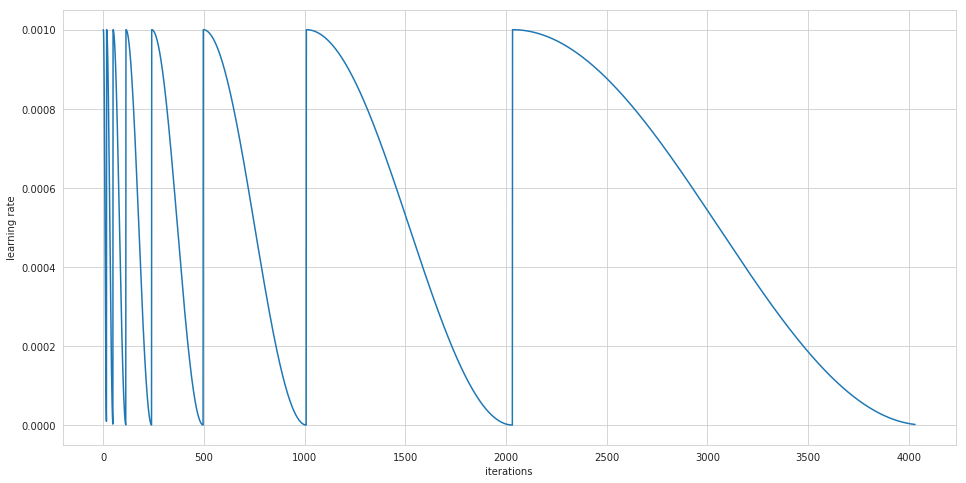

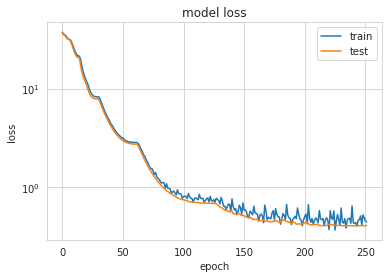

Fold took 781.145s


______________________________________
Training finished
Cross-validation took 8040.610s 
Mean loss = 0.47 +- 0.02
Mean AUC = 0.212 +- 0.002
Mean cut = 1.4e-05 +- 2e-06
Mean wAUC = 0.212 +- 0.002
Mean AMS = 371 +- 3
______________________________________



In [27]:
results, histories = batchTrainClassifier(trainDataTargetMod, nSplits, getModel, newModelArgs,
                                          trainParams, trainOnWeights=True, maxEpochs=maxEpochs,
                                          cosAnnealMult=2, reduxDecay=1,  # this line added
                                          patience=patience, verbose=1, amsSize=250000, binary=True,
                                          plotLR=plot_while_training, # plotMomentum=plot_while_training, 
                                          plot=plotLoss, 
                                          stopIfStallingTest=35,
                                         )

In [11]:
n = name_pretrain+'_model_step3p1'

In [ ]:
#model.save(n+'.h5')
with open(n+'.pkl', 'w') as f:
    pickle.dump((results, histories), f)

In [12]:
#model = load_model(n+'.h5', custom_objects=new_loss_functions)
with open(n+'.pkl') as f:
    results, histories = pickle.load(f)

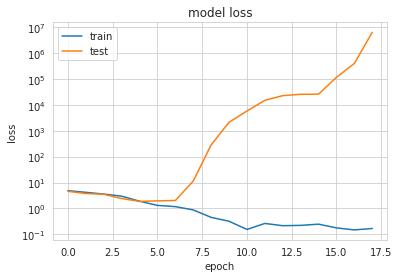

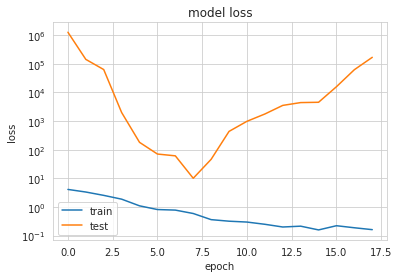

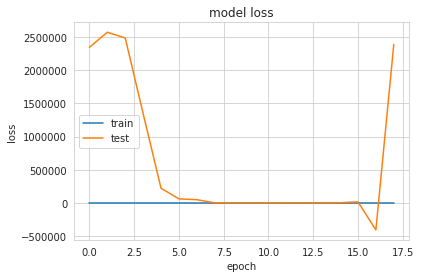

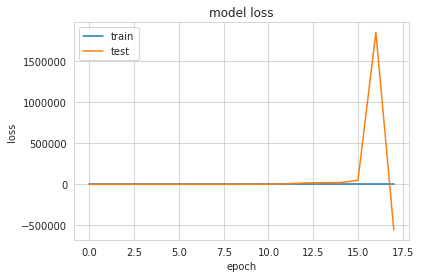

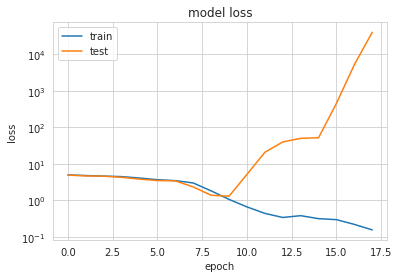

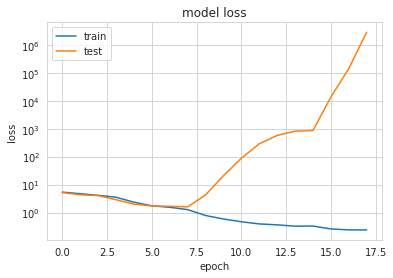

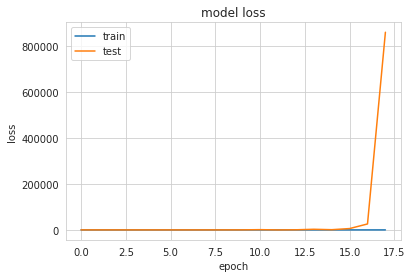

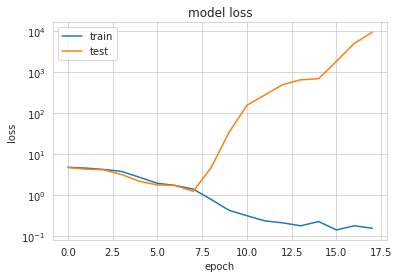

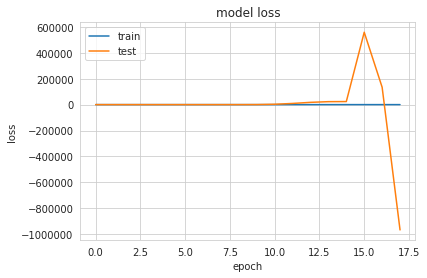

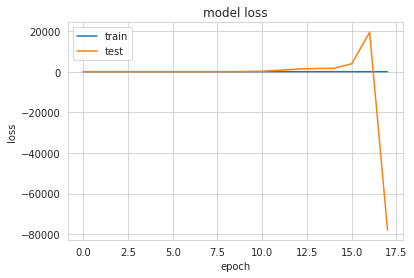

In [13]:
for i in range(len(histories)):
    plotLoss(histories[i])

## Construct ensemble

In [7]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:
    results = pickle.load(fin)

In [8]:
ensemble, weights = assembleEnsemble(
    results, ensembleSize, ensembleMode, compileArgs, custom_objects=new_loss_functions)

('Choosing ensemble by', 'loss')
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

('Model', 0, 'is', 6, 'with', 'loss', '=', 0.39628010463714597)
('Model', 1, 'is', 9, 'with', 'loss', '=', 0.4022966582169435)
('Model', 2, 'is', 3, 'with', 'loss', '=

## Response on validation datawith no ensembling

In [10]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [11]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 4.12829879418e-05s per sample

Predicting batch 2 out of 10
Prediction took 3.50147868495e-05s per sample

Predicting batch 3 out of 10
Prediction took 3.01247212869e-05s per sample

Predicting batch 4 out of 10
Prediction took 2.93012417978e-05s per sample

Predicting batch 5 out of 10
Prediction took 2.99027189612e-05s per sample

Predicting batch 6 out of 10
Prediction took 3.24320048094e-05s per sample

Predicting batch 7 out of 10
Prediction took 3.05657997896e-05s per sample

Predicting batch 8 out of 10
Prediction took 3.01997562271e-05s per sample

Predicting batch 9 out of 10
Prediction took 2.99434929498e-05s per sample

Predicting batch 10 out of 10
Prediction took 3.09285575433e-05s per sample

CPU times: user 49.5 s, sys: 2min 43s, total: 3min 33s
Wall time: 10.2 s


In [12]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.820316047743, weighted 0.820316047743


In [11]:
%%time
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')
CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 41.5 s


(3.574477842890102, 0.9527582)

In [12]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.6+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.947619539453, corresponds to AMS of 3.52228979407
CPU times: user 2.71 s, sys: 10 s, total: 12.7 s
Wall time: 57.8 s


(3.6, 0.95)

# Test scoring with no ensembling

In [20]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [21]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 3.52311047641e-05s per sample

Predicting batch 2 out of 10
Prediction took 3.53069262071e-05s per sample

Predicting batch 3 out of 10
Prediction took 3.40793089433e-05s per sample

Predicting batch 4 out of 10
Prediction took 3.57414549047e-05s per sample

Predicting batch 5 out of 10
Prediction took 4.16354005987e-05s per sample

Predicting batch 6 out of 10
Prediction took 3.62087639895e-05s per sample

Predicting batch 7 out of 10
Prediction took 3.70459816673e-05s per sample

Predicting batch 8 out of 10
Prediction took 3.47492521459e-05s per sample

Predicting batch 9 out of 10
Prediction took 3.80688537251e-05s per sample

Predicting batch 10 out of 10
Prediction took 3.47301613201e-05s per sample

CPU times: user 1min 44s, sys: 5min 43s, total: 7min 27s
Wall time: 20 s


In [44]:
scoreTestOD(testData.source, 0.9417530075879768)

Public:Private AMS: 3.18253691892 : 3.22240702412


(3.1825369189224144, 3.222407024124467)

## Response on validation data with ensembling

In [9]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [10]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000347135216068s per sample

Predicting batch 2 out of 10
Prediction took 0.000235731849588s per sample

Predicting batch 3 out of 10
Prediction took 0.000210897314791s per sample

Predicting batch 4 out of 10
Prediction took 0.000217039090932s per sample

Predicting batch 5 out of 10
Prediction took 0.000245668001473s per sample

Predicting batch 6 out of 10
Prediction took 0.000215399190784s per sample

Predicting batch 7 out of 10
Prediction took 0.000215832838927s per sample

Predicting batch 8 out of 10
Prediction took 0.000216060036581s per sample

Predicting batch 9 out of 10
Prediction took 0.000223658890228s per sample

Predicting batch 10 out of 10
Prediction took 0.000225090631087s per sample

CPU times: user 8min 24s, sys: 27min 47s, total: 36min 11s
Wall time: 1min 15s


In [11]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.790485657711, weighted 0.790485657711


In [19]:
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')


(3.715117458996407, 0.9555341)

In [20]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.8+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.950024582446, corresponds to AMS of 3.69339872363
CPU times: user 2.59 s, sys: 9.73 s, total: 12.3 s
Wall time: 56.6 s


(3.8, 0.95)

# Test scoring

In [15]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [16]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.000381626436927s per sample

Predicting batch 2 out of 10
Prediction took 0.000325065690821s per sample

Predicting batch 3 out of 10
Prediction took 0.000332086307352s per sample

Predicting batch 4 out of 10
Prediction took 0.000326267415827s per sample

Predicting batch 5 out of 10
Prediction took 0.000327129546079s per sample

Predicting batch 6 out of 10
Prediction took 0.000323580308394s per sample

Predicting batch 7 out of 10
Prediction took 0.000327063855258s per sample

Predicting batch 8 out of 10
Prediction took 0.000326154544137s per sample

Predicting batch 9 out of 10
Prediction took 0.000326552473415s per sample

Predicting batch 10 out of 10
Prediction took 0.000326488633589s per sample

CPU times: user 15min 57s, sys: 52min 37s, total: 1h 8min 35s
Wall time: 3min 2s


In [23]:
scoreTestOD(testData.source, 0.9394347775960341)

Public:Private AMS: 3.6170575304 : 3.61021225312


(3.6170575303988963, 3.610212253117004)

# Save/Load

In [12]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=True)

In [6]:
ensemble, weights, compileArgs, _, _ = loadEnsemble(name, custom_objects=new_loss_functions)

# Plotting

(320000, 'candidates loaded')


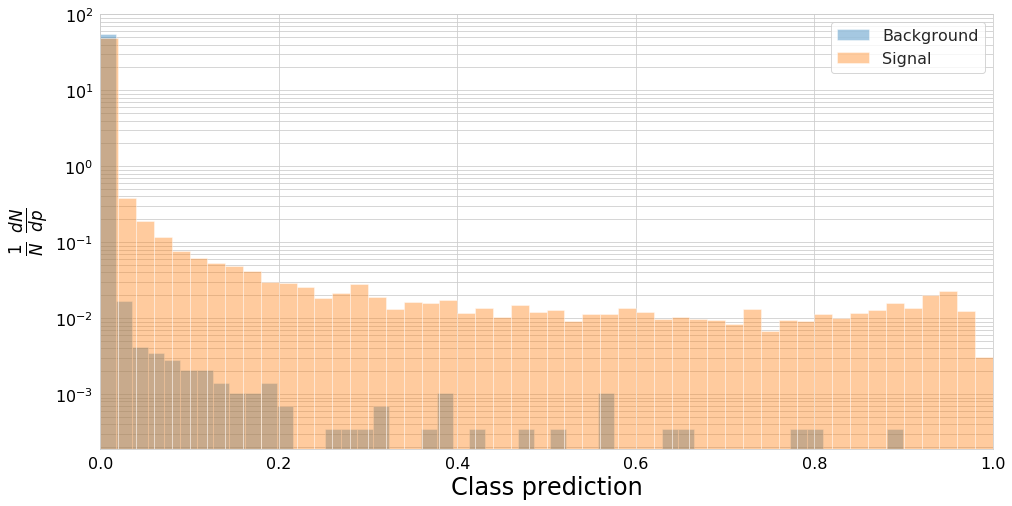

In [18]:
# TODO log-x
d = convertToDF(valData.source)

s_norm = s_exp/np.sum(d['gen_weight'][d['gen_target']==1])
b_norm = b_exp/np.sum(d['gen_weight'][d['gen_target']==0])

d['final_weight']                         = d['gen_weight']*s_norm
d.loc[d['gen_target']==0, 'final_weight'] = d['gen_weight']*b_norm

bkg_sig_dfs = [
    d[d['gen_target']==0],
    d[d['gen_target']==1],
]
getClassPredPlot(bkg_sig_dfs, weightName='final_weight')

0 ROC AUC: 0.790485657711


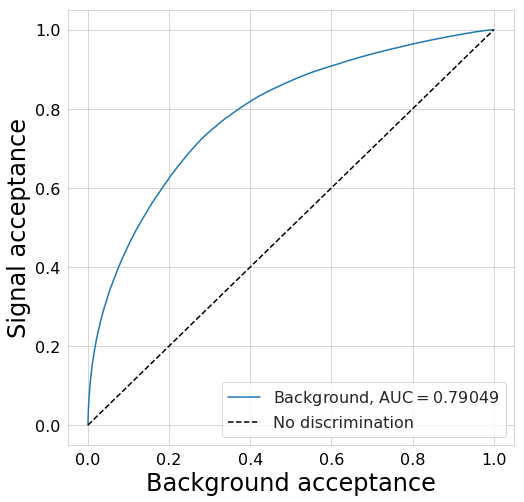

In [19]:
rocPlot([d], weightName='final_weight', labels=['Background', 'Signal'])

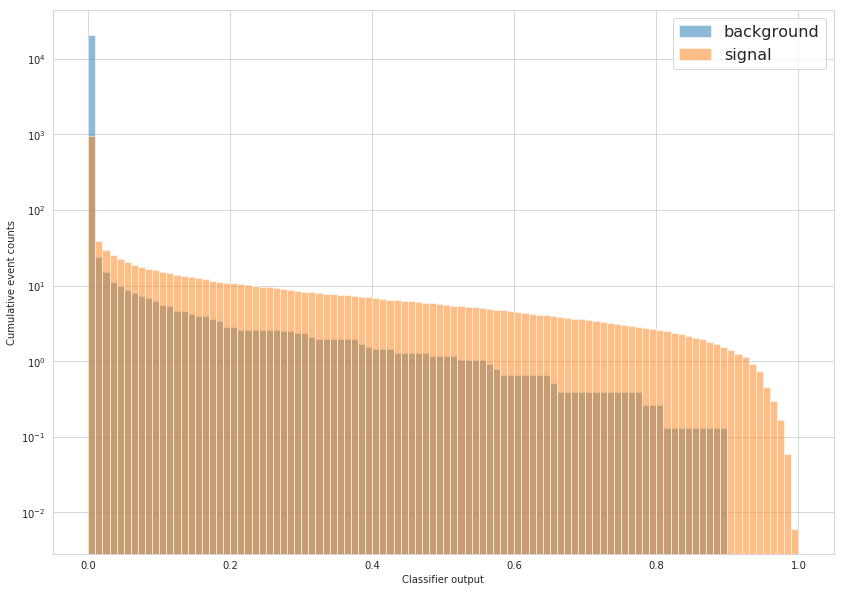

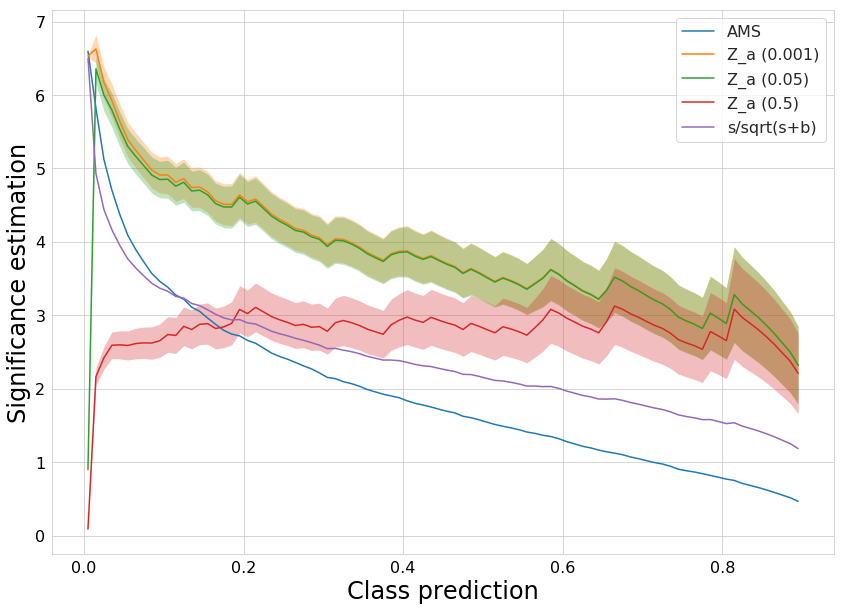

In [21]:
src = valData
#src = testData
from numpy import sqrt, log, power

def get_asimov(systematic):
    return lambda s,b: (Z_asimov(s,b, systematic), 
                        eZ_asimov(s,sqrt(s/s_norm)*s_norm,b,sqrt(b/b_norm)*b_norm,systematic))

h1 = plotSignificanceEstimate(
    d, 
    {
        #'s/sqrt(b)': lambda s,b: s/np.sqrt(b),
        's/sqrt(s+b)': lambda s,b: s/np.sqrt(s+b),
        'Z_a (0.5)': get_asimov(0.5),
        'Z_a (0.05)': get_asimov(0.05),
        'Z_a (0.001)': get_asimov(0.001),
        'AMS': AMS,
#        'asimov err': lambda s,b: eZ(s,sqrt(s),b,sqrt(b)),
    },
    weightName='final_weight',
    figsize=(14, 10),
    nBins=100,
)